In [ ]:
!pip install -q joblib seaborn ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

%matplotlib inline

  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('dataset.csv')
print("Original Columns:", df.columns.tolist())
df.head()

Saving dataset.csv to dataset.csv
Original Columns: ['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp', 'crypto_name', 'date']


,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.0,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.0,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.0,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.0,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.0,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07


In [ ]:
df = df.rename(columns={
    'crypto_name': 'symbol',
    'marketCap': 'market_cap'
})
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

df = df.sort_values(['symbol', 'date']).reset_index(drop=True)

df = df.groupby('symbol').apply(lambda g: g.ffill().bfill()).reset_index(drop=True)

print(" Data cleaned and sorted successfully!")
print("Columns:", df.columns.tolist())
print("Rows:", df.shape[0])

 Data cleaned and sorted successfully!
Columns: ['open', 'high', 'low', 'close', 'volume', 'market_cap', 'timestamp', 'symbol', 'date']
Rows: 72946


/tmp/ipython-input-2867536060.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('symbol').apply(lambda g: g.ffill().bfill()).reset_index(drop=True)


               open          high           low         close        volume  \
count  72946.000000  7.294600e+04  72946.000000  7.294600e+04  7.294600e+04   
mean     870.194495  8.964124e+02    844.060640  8.712949e+02  2.207607e+09   
min        0.000000  1.022100e-10      0.000000  8.292000e-11  0.000000e+00   
25%        0.167916  1.767999e-01      0.158630  1.682982e-01  8.320618e+06   
50%        1.630666  1.717542e+00      1.541486  1.640219e+00  1.098756e+08   
75%       26.070557  2.756868e+01     24.791776  2.625195e+01  6.691398e+08   
max    67549.735581  1.621883e+05  66458.723733  6.756683e+04  3.509679e+11   
std     5231.654470  5.398613e+03   5079.389387  5.235508e+03  9.617885e+09   

         market_cap                           date  
count  7.294600e+04                          72946  
mean   1.474922e+10  2019-10-13 03:20:59.945713152  
min    0.000000e+00            2013-05-05 00:00:00  
25%    1.860432e+08            2018-09-08 00:00:00  
50%    1.268539e+09    

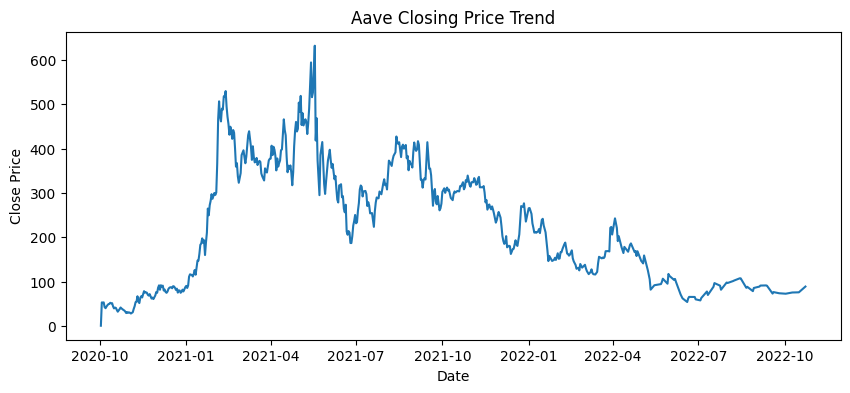

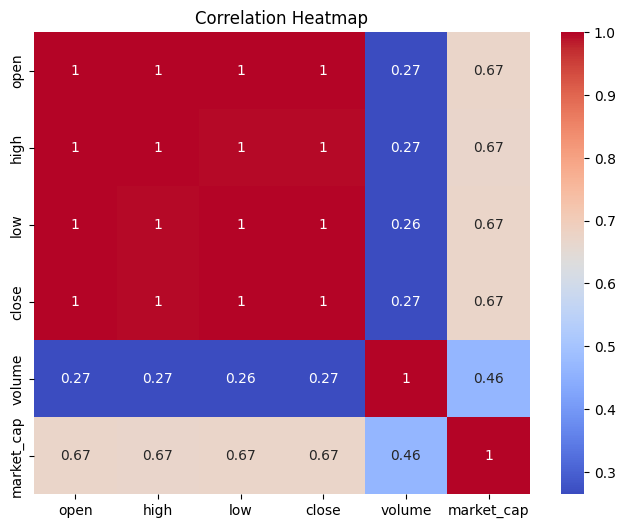

In [ ]:
print(df.describe())

print("Unique Cryptos:", df['symbol'].nunique())

coin = df['symbol'].unique()[0]
sample = df[df['symbol'] == coin]

plt.figure(figsize=(10,4))
plt.plot(sample['date'], sample['close'])
plt.title(f"{coin} Closing Price Trend")
plt.xlabel("Date"); plt.ylabel("Close Price")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df[['open','high','low','close','volume','market_cap']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
df['daily_return'] = (df['close'] - df['open']) / df['open']

df['vol_7d']  = df.groupby('symbol')['daily_return'].rolling(7).std().reset_index(0,drop=True)
df['vol_14d'] = df.groupby('symbol')['daily_return'].rolling(14).std().reset_index(0,drop=True)

df['market_cap'] = df['market_cap'].replace(0, np.nan)
df['liquidity_ratio'] = df['volume'] / df['market_cap']

df['ma7']  = df.groupby('symbol')['close'].rolling(7).mean().reset_index(0,drop=True)
df['ma30'] = df.groupby('symbol')['close'].rolling(30).mean().reset_index(0,drop=True)

rolling_mean = df.groupby('symbol')['close'].rolling(20).mean().reset_index(0,drop=True)
rolling_std  = df.groupby('symbol')['close'].rolling(20).std().reset_index(0,drop=True)
df['bb_upper'] = rolling_mean + 2*rolling_std
df['bb_lower'] = rolling_mean - 2*rolling_std

df['tr1'] = df['high'] - df['low']
df['tr2'] = (df['high'] - df['close'].shift(1)).abs()
df['tr3'] = (df['low'] - df['close'].shift(1)).abs()
df['true_range'] = df[['tr1','tr2','tr3']].max(axis=1)
df['atr_14'] = df.groupby('symbol')['true_range'].rolling(14).mean().reset_index(0,drop=True)

df = df.drop(columns=['tr1','tr2','tr3','true_range'])
df = df.replace([np.inf, -np.inf], np.nan).dropna()


print(" Feature Engineering Done! Shape:", df.shape)
df.head()

 Feature Engineering Done! Shape: (66678, 18)


,open,high,low,close,volume,market_cap,timestamp,symbol,date,daily_return,vol_7d,vol_14d,liquidity_ratio,ma7,ma30,bb_upper,bb_lower,atr_14
87,80.855245,87.699875,78.426047,87.527482,2.044713e+08,1.053210e+09,2020-12-31T23:59:59.999Z,Aave,2020-12-31,0.082521,0.057864,0.057179,0.194141,79.885882,83.002239,92.165132,72.436377,8.682780
88,87.543306,90.349671,85.125597,90.349671,2.025158e+08,1.087593e+09,2021-01-01T23:59:59.999Z,Aave,2021-01-01,0.032057,0.054539,0.057376,0.186206,81.327753,83.518282,92.895490,73.268003,8.617762
89,90.384828,91.771620,82.785763,85.712843,2.218439e+08,1.032020e+09,2021-01-02T23:59:59.999Z,Aave,2021-01-02,-0.051690,0.059688,0.057048,0.214961,82.173134,83.497935,93.009919,73.969370,8.764438
90,85.712989,92.429110,81.853375,91.096650,2.988841e+08,1.097390e+09,2021-01-03T23:59:59.999Z,Aave,2021-01-03,0.062810,0.054218,0.059770,0.272359,84.491465,83.478635,93.982412,73.763796,9.012377
91,91.230496,111.899874,88.201610,111.132038,6.192624e+08,1.339476e+09,2021-01-04T23:59:59.999Z,Aave,2021-01-04,0.218146,0.091329,0.082282,0.462317,89.372044,84.461643,100.964825,69.280575,10.318706


In [ ]:
features = ['open','high','low','close','volume','market_cap',
            'daily_return','liquidity_ratio','ma7','ma30','atr_14']
target = 'vol_7d'

X = df[features]
y = df[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n = len(X_scaled)
split = int(n * 0.8)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

print(" Model trained successfully!")

 Model trained successfully!


MAE : 0.015471
RMSE: 0.028771
R²  : 0.5573


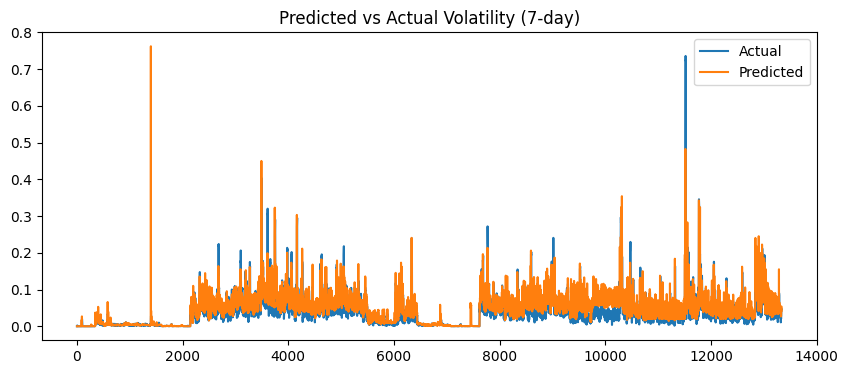

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²  : {r2:.4f}")

plt.figure(figsize=(10,4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend(); plt.title("Predicted vs Actual Volatility (7-day)")
plt.show()

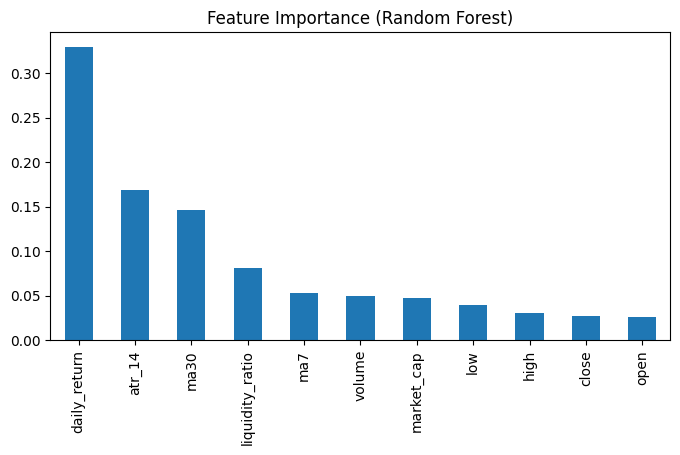

 Model and scaler saved to working directory


In [ ]:
imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,4))
imp.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.show()

joblib.dump(model, 'crypto_volatility_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print(" Model and scaler saved to working directory")